# 01. EUNIS Data Download & Exploration

This notebook handles the exploration of EUNIS MapServer services and performs the bulk download of raw data.

**Goal:**
1. List available services.
2. Preview specific datasets to understand the schema without downloading everything.
3. Stream download all datasets to `data/raw/eunis`.
4. Verify the downloaded data.

In [1]:
import asyncio
import logging
import sys
import geopandas as gpd
from pathlib import Path

# Adjust path to import src
sys.path.append(str(Path.cwd().parent))
from src.eunis_client import EunisClient

# Configure Logging to see progress in the notebook
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)

## 1. List Available Services
Let's see what datasets are available on the server.

In [2]:
async def list_available_data():
    async with EunisClient() as client:
        services = await client.list_services()
        print(f"Found {len(services)} services.")
        for s in services:
            print(f"- {s['name']} ({s['type']})")
            
# Run async code in notebook
await list_available_data()

01:48:32 - INFO - HTTP Request: GET https://bio.discomap.eea.europa.eu/arcgis/rest/services/EUNIS?f=json "HTTP/1.1 200 OK"


Found 25 services.
- EUNIS/Coastal_Distribution_point (MapServer)
- EUNIS/Con_Prob_T3G2_3 (ImageServer)
- EUNIS/Forest_Distribution_point (MapServer)
- EUNIS/Grassland_Distribution_point (MapServer)
- EUNIS/Hethland_Distribution_point (MapServer)
- EUNIS/Mosaic_Coastal (ImageServer)
- EUNIS/Mosaic_Forest (ImageServer)
- EUNIS/Mosaic_Grassland (ImageServer)
- EUNIS/Mosaic_Heathlands (ImageServer)
- EUNIS/Mosaic_Saltmarshes (ImageServer)
- EUNIS/Mosaic_Sparsely (ImageServer)
- EUNIS/Mosaic_Vegetated (ImageServer)
- EUNIS/MosaicProb_Coastal (ImageServer)
- EUNIS/MosaicProb_Forest (ImageServer)
- EUNIS/MosaicProb_Grassland (ImageServer)
- EUNIS/MosaicProb_Heathland (ImageServer)
- EUNIS/MosaicProb_Saltmarshes (ImageServer)
- EUNIS/MosaicProb_Sparsely (ImageServer)
- EUNIS/MosaicProb_Wetlands (ImageServer)
- EUNIS/MosaicSuit_Wetlands (ImageServer)
- EUNIS/R21_Prob_test (ImageServer)
- EUNIS/Saltmarshes_Distribution_point (MapServer)
- EUNIS/Sparsely_Distribution_point (MapServer)
- EUNIS/Ve

## 2. Data Preview (EDA)
Before downloading everything, let's peek at a specific dataset (e.g., 'EUNIS/Marine_Habitat') to check attributes and geometry types.

01:48:36 - INFO - Previewing 100 rows from EUNIS/Coastal_Distribution_point/0...
01:48:37 - INFO - HTTP Request: GET https://bio.discomap.eea.europa.eu/arcgis/rest/services/EUNIS/Coastal_Distribution_point/MapServer/0/query?where=1%3D1&outFields=%2A&returnGeometry=true&resultRecordCount=100&f=geojson "HTTP/1.1 200 OK"


Schema for EUNIS/Coastal_Distribution_point:
geometry      geometry
OBJECTID         int64
PLOTOBSID        int64
YEAR               str
PRECISION          str
HabitatCod         str
Code_              str
Name_              str
Descriptio         str
Plot               str
dtype: object


,geometry,OBJECTID,PLOTOBSID,YEAR,PRECISION,HabitatCod,Code_,Name_,Descriptio,Plot
0,POINT (-4.41999 43.38905),1,87965,1985,5000,N11,N11,"Atlantic, Baltic and Arctic sand beach","Atlantic, Baltic and Arctic sandy beach is a l...",N11
1,POINT (-3.44048 43.42933),2,96624,1987,500,N11,N11,"Atlantic, Baltic and Arctic sand beach","Atlantic, Baltic and Arctic sandy beach is a l...",N11
2,POINT (-3.44048 43.42933),3,96625,1987,500,N11,N11,"Atlantic, Baltic and Arctic sand beach","Atlantic, Baltic and Arctic sandy beach is a l...",N11
3,POINT (-3.46546 43.46526),4,96626,1987,500,N11,N11,"Atlantic, Baltic and Arctic sand beach","Atlantic, Baltic and Arctic sandy beach is a l...",N11
4,POINT (-3.45277 43.42027),5,96627,1987,500,N11,N11,"Atlantic, Baltic and Arctic sand beach","Atlantic, Baltic and Arctic sandy beach is a l...",N11


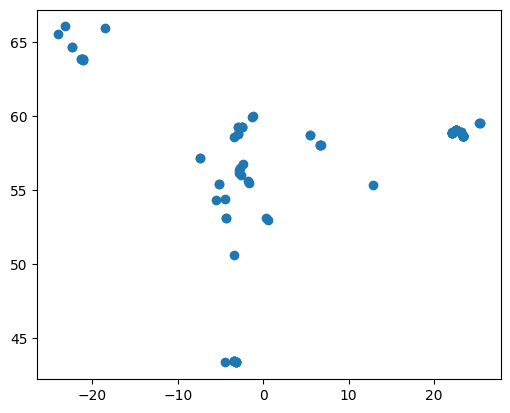

In [3]:
target_service = "EUNIS/Coastal_Distribution_point"  # Change this to a real service name from the list above

async def preview_data():
    async with EunisClient() as client:
        # Fetch only top 100 rows
        gdf = await client.get_preview(target_service, limit=100)
        return gdf

gdf_preview = await preview_data()

if not gdf_preview.empty:
    print(f"Schema for {target_service}:")
    print(gdf_preview.dtypes)
    display(gdf_preview.head())
    
    # Simple plot to verify geometry
    gdf_preview.plot()
else:
    print("No data found or service name is incorrect.")

## 3. Bulk Download
This step downloads all MapServer datasets to `data/raw/eunis`.

In [4]:
async def run_download():
    async with EunisClient() as client:
        await client.download_all_datasets(output_dir="../data/raw/eunis")

# Uncomment to run the full download (Time consuming)
await run_download()

01:49:03 - INFO - HTTP Request: GET https://bio.discomap.eea.europa.eu/arcgis/rest/services/EUNIS?f=json "HTTP/1.1 200 OK"
01:49:03 - INFO - Found 8 MapServer datasets.
01:49:03 - INFO - Streaming EUNIS/Coastal_Distribution_point to ../data/raw/eunis/EUNIS_Coastal_Distribution_point.geojson...
01:49:03 - INFO - HTTP Request: GET https://bio.discomap.eea.europa.eu/arcgis/rest/services/EUNIS/Coastal_Distribution_point/MapServer?f=json "HTTP/1.1 200 OK"
01:49:03 - INFO - [EUNIS/Coastal_Distribution_point] Server limit: 2000 records per request.
01:49:03 - INFO - HTTP Request: GET https://bio.discomap.eea.europa.eu/arcgis/rest/services/EUNIS/Coastal_Distribution_point/MapServer/0/query?where=1%3D1&returnIdsOnly=true&f=json "HTTP/1.1 200 OK"
01:49:03 - INFO - [EUNIS/Coastal_Distribution_point] Found 34102 features. Starting stream...
01:49:03 - INFO - HTTP Request: POST https://bio.discomap.eea.europa.eu/arcgis/rest/services/EUNIS/Coastal_Distribution_point/MapServer/0/query "HTTP/1.1 200 O

## 4. Verify Download
Load one of the downloaded files to ensure it's valid GeoJSON and can be read by GeoPandas.

In [5]:
raw_dir = Path("../data/raw/eunis")
files = list(raw_dir.glob("*.geojson"))

if files:
    test_file = files[0]
    print(f"Verifying {test_file}...")
    
    try:
        # Read file
        gdf_verify = gpd.read_file(test_file)
        print(f"Success! Loaded {len(gdf_verify)} rows.")
        display(gdf_verify.head(3))
    except Exception as e:
        print(f"Error reading file: {e}")
else:
    print("No files found. Did you run the download step?")

Verifying ../data/raw/eunis/EUNIS_Wetlands_Distribution_point.geojson...
Success! Loaded 92468 rows.


,OBJECTID,PLOTOBSID,YEAR,HabitatCod,Level,Code_,Name_,Code_tif,Plot,PRECISION,Descriptio,geometry
0,1,37870,,Q11,3,Q11,Raised bog,Q11_data.tif,Q11,NaN,The mire surface and underlying peat of highly...,POINT (13.49821 47.84702)
1,2,37982,,Q11,3,Q11,Raised bog,Q11_data.tif,Q11,NaN,The mire surface and underlying peat of highly...,POINT (9.85667 47.07085)
2,3,37985,,Q11,3,Q11,Raised bog,Q11_data.tif,Q11,NaN,The mire surface and underlying peat of highly...,POINT (9.85727 47.07126)
